In [1]:
from collections import defaultdict
from typing import List

import os
import pandas as pd
import seaborn as sns
import re
import io

In [2]:
data_path = "../data/part4/task1"

core_list =["0", "0,1"]
num_threads = [1, 2]
num_runs=3

In [3]:
def parse_lines(file_path: str) -> List[float]:
    return 

def get_data(core_list, num_threads, num_runs):
    data = defaultdict(list)
    for core in core_list:
        for threads in num_threads:
            for run in range(num_runs):
                file_name = f"run_{run+1}/{core}_cpu_{threads}_threads.txt"
                file_path = os.path.join(data_path, file_name)
                if os.path.exists(file_path):
                    with open(file_path, "r") as f:
                        lines = f.readlines()[2:-2] # skip first two and last two lines
                        data_str = ''.join(lines)
                        df = pd.read_csv(io.StringIO(data_str), sep='\s+')
                        data[(core, threads)].append(df)
                else:
                    print(f"File {file_path} does not exist.")
    return data

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_29349/4086209413.py:15: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(io.StringIO(data_str), sep='\s+')


In [4]:
data = get_data(core_list, num_threads, num_runs)

In [5]:
data[("0", 1)][0].columns

Index(['#type', 'avg', 'std', 'min', 'p5', 'p10', 'p50', 'p67', 'p75', 'p80',
       'p85', 'p90', 'p95', 'p99', 'p999', 'p9999', 'QPS', 'target',
       'ts_start', 'ts_end'],
      dtype='object')

In [6]:
def process_data(df_list, column="QPS"):

    tmp = pd.concat(df_list, axis=0)

    mean = tmp[column].groupby(tmp.index).mean()
    std = tmp[column].groupby(tmp.index).std()

    return mean, std

achieved_qps = {k: process_data(v, 'QPS') for k, v in data.items()} 
p95 = {k: process_data(v, 'p95') for k, v in data.items()}

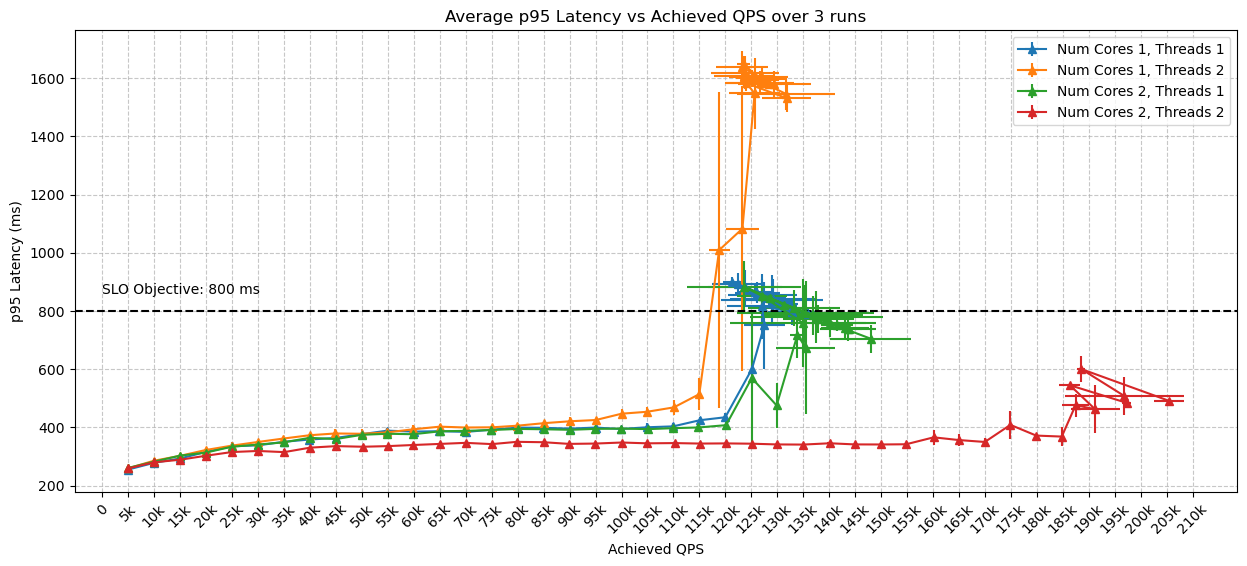

In [10]:
import matplotlib.pyplot as plt
import numpy as np

slo_latency = 800

plt.figure(figsize=(15, 6))

for k in achieved_qps.keys():
    qps_mean, qps_std = achieved_qps[k]
    p95_mean, p95_std = p95[k]

    plt.errorbar(qps_mean, p95_mean, xerr=qps_std, yerr=p95_std, label=f"Num Cores {len(k[0].split(','))}, Threads {k[1]}", marker='^', linestyle='-')

plt.axhline(y=slo_latency, color='black', linestyle='--')
plt.text(0, slo_latency + 50, f"SLO Objective: {slo_latency} ms", color='black', fontsize=10, ha='left', va='bottom')


plt.title("Average p95 Latency vs Achieved QPS over 3 runs")
#plt.suptitle("Memcached with different Number of Cores and Threads")
plt.grid(True, linestyle='--', alpha=0.7)

# Find the maximum QPS value for setting the x-axis range
max_qps = max([qps_mean.max() for qps_mean, _ in achieved_qps.values()])
# Round up to the nearest 5000
max_qps_rounded = np.ceil(max_qps / 5000) * 5000
x_ticks = np.arange(0, max_qps_rounded + 5000, 5000)
plt.xticks(x_ticks, [f"{int(x//1000)}k" if x != 0 else 0 for x in x_ticks], rotation=45)
plt.xticks()

plt.xlabel("Achieved QPS")
plt.ylabel("p95 Latency (ms)")
plt.legend()